In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import torch.utils.data.sampler as sampler

import os
import fnmatch
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
'DATA LOADER'
class CityScapes(Dataset):
    def __init__(self, root, train=True):
        self.train = train
        self.root = os.path.expanduser(root)

        # read the data file
        if train:
            self.data_path = root + '/train'
        else:
            self.data_path = root + '/val'

        # calculate data length
        self.data_len = len(fnmatch.filter(os.listdir(self.data_path + '/image'), '*.npy'))

    def __getitem__(self, index):
        # load data from the pre-processed npy files
        image = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/image/{:d}.npy'.format(index)), -1, 0))
        semantic = torch.from_numpy(np.load(self.data_path + '/label/{:d}.npy'.format(index)))
        depth = torch.from_numpy(np.moveaxis(np.load(self.data_path + '/depth/{:d}.npy'.format(index)), -1, 0))
        
        return image.float(), semantic.float(), depth.float()

    def __len__(self):
        return self.data_len

In [12]:
'utility functions'
def model_fit(x_pred, x_output, task_type):
    device = x_pred.device

    # binary mark to mask out undefined pixel space
    binary_mask = (torch.sum(x_output, dim=1) != 0).float().unsqueeze(1).to(device)

    if task_type == 'semantic':
        # semantic loss: depth-wise cross entropy
        loss = F.nll_loss(x_pred, x_output, ignore_index=-1)

    if task_type == 'depth':
        # depth loss: l1 norm
        loss = torch.sum(torch.abs(x_pred - x_output) * binary_mask) / torch.nonzero(binary_mask, as_tuple=False).size(0)

    return loss


# mIoU and Acc. formula: accumulate every pixel and average across all pixels in all images
class ConfMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, pred, target):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=pred.device)
        with torch.no_grad():
            k = (target >= 0) & (target < n)
            inds = n * target[k].to(torch.int64) + pred[k]
            self.mat += torch.bincount(inds, minlength=n ** 2).reshape(n, n)

    def get_metrics(self):
        print('yes')
        h = self.mat.float()
        acc = torch.diag(h).sum() / h.sum()
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return torch.mean(iu), acc
    

def depth_error(x_pred, x_output):
    device = x_pred.device
    binary_mask = (torch.sum(x_output, dim=1) != 0).unsqueeze(1).to(device)
    x_pred_true = x_pred.masked_select(binary_mask)
    x_output_true = x_output.masked_select(binary_mask)
    abs_err = torch.abs(x_pred_true - x_output_true)
    rel_err = torch.abs(x_pred_true - x_output_true) / x_output_true
    return (torch.sum(abs_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)).item(), \
           (torch.sum(rel_err) / torch.nonzero(binary_mask, as_tuple=False).size(0)).item()


def multi_task_trainer(train_loader, test_loader, multi_task_model, device, optimizer, scheduler, config, total_epoch=200):
    train_batch = len(train_loader)
    test_batch = len(test_loader)
    
    T = config['temp']
    avg_cost = np.zeros([total_epoch, 12], dtype=np.float32)
    lambda_weight = np.ones([2, total_epoch])
    
    for index in range(total_epoch):
        cost = np.zeros(12, dtype=np.float32)

        # apply Dynamic Weight Average
        if config['weight'] == 'dwa':
            if index == 0 or index == 1:
                lambda_weight[:, index] = 1.0
            else:
                w_1 = avg_cost[index - 1, 0] / avg_cost[index - 2, 0]
                w_2 = avg_cost[index - 1, 3] / avg_cost[index - 2, 3]
                lambda_weight[0, index] = 2 * np.exp(w_1 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T))
                lambda_weight[1, index] = 2 * np.exp(w_2 / T) / (np.exp(w_1 / T) + np.exp(w_2 / T))

        # iteration for all batches
        multi_task_model.train()
        train_dataset = iter(train_loader)
        conf_mat = ConfMatrix(multi_task_model.class_nb)
        for k in range(train_batch):
            train_data, train_label, train_depth = next(train_dataset)
            train_data, train_label = train_data.to(device), train_label.long().to(device)
            train_depth = train_depth.to(device)

            train_pred, logsigma = multi_task_model(train_data)

            optimizer.zero_grad()
            train_loss = [model_fit(train_pred[0], train_label, 'semantic'),
                          model_fit(train_pred[1], train_depth, 'depth')]

            if config['weight'] == 'equal' or config['weight'] == 'dwa':
                loss = sum([lambda_weight[i, index] * train_loss[i] for i in range(2)])
            else:
                loss = sum(1 / (2 * torch.exp(logsigma[i])) * train_loss[i] + logsigma[i] / 2 for i in range(2))

            loss.backward()
            optimizer.step()

            # accumulate label prediction for every pixel in training images
            conf_mat.update(train_pred[0].argmax(1).flatten(), train_label.flatten())

            cost[0] = train_loss[0].item()
            cost[3] = train_loss[1].item()
            cost[4], cost[5] = depth_error(train_pred[1], train_depth)
            avg_cost[index, :6] += cost[:6] / train_batch

        # compute mIoU and acc
        metrics = conf_mat.get_metrics()
        metrics = [metric.cpu().numpy() for metric in metrics]
        avg_cost[index, 1:3] = metrics
        
        #avg_cost[index, 1:3] = conf_mat.get_metrics().cpu().numpy()

        # evaluating test data
        multi_task_model.eval()
        conf_mat = ConfMatrix(multi_task_model.class_nb)
        with torch.no_grad():  # operations inside don't track history
            test_dataset = iter(test_loader)
            for k in range(test_batch):
                test_data, test_label, test_depth = next(test_dataset)
                test_data, test_label = test_data.to(device), test_label.long().to(device)
                test_depth = test_depth.to(device)

                test_pred, _ = multi_task_model(test_data)
                test_loss = [model_fit(test_pred[0], test_label, 'semantic'),
                             model_fit(test_pred[1], test_depth, 'depth')]

                conf_mat.update(test_pred[0].argmax(1).flatten(), test_label.flatten())

                cost[6] = test_loss[0].item()
                cost[9] = test_loss[1].item()
                cost[10], cost[11] = depth_error(test_pred[1], test_depth)
                avg_cost[index, 6:] += cost[6:] / test_batch

            # compute mIoU and acc
            avg_cost[index, 7:9] = conf_mat.get_metrics()

        scheduler.step()
        print('Epoch: {:04d} | TRAIN: {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f} ||'
            'TEST: {:.4f} {:.4f} {:.4f} | {:.4f} {:.4f} {:.4f} '
            .format(index, avg_cost[index, 0], avg_cost[index, 1], avg_cost[index, 2], avg_cost[index, 3],
                    avg_cost[index, 4], avg_cost[index, 5], avg_cost[index, 6], avg_cost[index, 7], avg_cost[index, 8],
                    avg_cost[index, 9], avg_cost[index, 10], avg_cost[index, 11]))

In [4]:
'NETWORK'
class SegNet(nn.Module):
    def __init__(self):
        super(SegNet, self).__init__()
        
        # initialise network parameters
        filter = [64, 128, 256, 512, 512]
        self.class_nb = 19

        # define encoder decoder layers
        self.encoder_block = nn.ModuleList([self.conv_layer([3, filter[0]])])
        self.decoder_block = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            self.encoder_block.append(self.conv_layer([filter[i], filter[i + 1]]))
            self.decoder_block.append(self.conv_layer([filter[i + 1], filter[i]]))

        # define convolution layer
        self.conv_block_enc = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        self.conv_block_dec = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])
        for i in range(4):
            if i == 0:
                self.conv_block_enc.append(self.conv_layer([filter[i + 1], filter[i + 1]]))
                self.conv_block_dec.append(self.conv_layer([filter[i], filter[i]]))
            else:
                self.conv_block_enc.append(nn.Sequential(self.conv_layer([filter[i + 1], filter[i + 1]]),
                                                         self.conv_layer([filter[i + 1], filter[i + 1]])))
                self.conv_block_dec.append(nn.Sequential(self.conv_layer([filter[i], filter[i]]),
                                                         self.conv_layer([filter[i], filter[i]])))

        # define task attention layers
        self.encoder_att = nn.ModuleList([nn.ModuleList([self.att_layer([filter[0], filter[0], filter[0]])])])
        self.decoder_att = nn.ModuleList([nn.ModuleList([self.att_layer([2 * filter[0], filter[0], filter[0]])])])
        self.encoder_block_att = nn.ModuleList([self.conv_layer([filter[0], filter[1]])])
        self.decoder_block_att = nn.ModuleList([self.conv_layer([filter[0], filter[0]])])

        for j in range(2):
            if j < 2:
                self.encoder_att.append(nn.ModuleList([self.att_layer([filter[0], filter[0], filter[0]])]))
                self.decoder_att.append(nn.ModuleList([self.att_layer([2 * filter[0], filter[0], filter[0]])]))
            for i in range(4):
                self.encoder_att[j].append(self.att_layer([2 * filter[i + 1], filter[i + 1], filter[i + 1]]))
                self.decoder_att[j].append(self.att_layer([filter[i + 1] + filter[i], filter[i], filter[i]]))

        for i in range(4):
            if i < 3:
                self.encoder_block_att.append(self.conv_layer([filter[i + 1], filter[i + 2]]))
                self.decoder_block_att.append(self.conv_layer([filter[i + 1], filter[i]]))
            else:
                self.encoder_block_att.append(self.conv_layer([filter[i + 1], filter[i + 1]]))
                self.decoder_block_att.append(self.conv_layer([filter[i + 1], filter[i + 1]]))

        self.pred_task1 = self.conv_layer([filter[0], self.class_nb], pred=True)
        self.pred_task2 = self.conv_layer([filter[0], 1], pred=True)

        # define pooling and unpooling functions
        self.down_sampling = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)
        self.up_sampling = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.logsigma = nn.Parameter(torch.FloatTensor([-0.5, -0.5, -0.5]))

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def conv_layer(self, channel, pred=False):
        if not pred:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=3, padding=1),
                nn.BatchNorm2d(num_features=channel[1]),
                nn.ReLU(inplace=True),
            )
        else:
            conv_block = nn.Sequential(
                nn.Conv2d(in_channels=channel[0], out_channels=channel[0], kernel_size=3, padding=1),
                nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=1, padding=0),
            )
        return conv_block

    def att_layer(self, channel):
        att_block = nn.Sequential(
            nn.Conv2d(in_channels=channel[0], out_channels=channel[1], kernel_size=1, padding=0),
            nn.BatchNorm2d(channel[1]),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=channel[1], out_channels=channel[2], kernel_size=1, padding=0),
            nn.BatchNorm2d(channel[2]),
            nn.Sigmoid(),
        )
        return att_block

    def forward(self, x):
        g_encoder, g_decoder, g_maxpool, g_upsampl, indices = ([0] * 5 for _ in range(5))
        for i in range(5):
            g_encoder[i], g_decoder[-i - 1] = ([0] * 2 for _ in range(2))

        # define attention list for tasks
        atten_encoder, atten_decoder = ([0] * 3 for _ in range(2))
        for i in range(2):
            atten_encoder[i], atten_decoder[i] = ([0] * 5 for _ in range(2))
        for i in range(2):
            for j in range(5):
                atten_encoder[i][j], atten_decoder[i][j] = ([0] * 3 for _ in range(2))

        # define global shared network
        for i in range(5):
            if i == 0:
                g_encoder[i][0] = self.encoder_block[i](x)
                g_encoder[i][1] = self.conv_block_enc[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])
            else:
                g_encoder[i][0] = self.encoder_block[i](g_maxpool[i - 1])
                g_encoder[i][1] = self.conv_block_enc[i](g_encoder[i][0])
                g_maxpool[i], indices[i] = self.down_sampling(g_encoder[i][1])

        for i in range(5):
            if i == 0:
                g_upsampl[i] = self.up_sampling(g_maxpool[-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.conv_block_dec[-i - 1](g_decoder[i][0])
            else:
                g_upsampl[i] = self.up_sampling(g_decoder[i - 1][-1], indices[-i - 1])
                g_decoder[i][0] = self.decoder_block[-i - 1](g_upsampl[i])
                g_decoder[i][1] = self.conv_block_dec[-i - 1](g_decoder[i][0])

        # define task dependent attention module
        for i in range(2):
            for j in range(5):
                if j == 0:
                    atten_encoder[i][j][0] = self.encoder_att[i][j](g_encoder[j][0])
                    atten_encoder[i][j][1] = (atten_encoder[i][j][0]) * g_encoder[j][1]
                    atten_encoder[i][j][2] = self.encoder_block_att[j](atten_encoder[i][j][1])
                    atten_encoder[i][j][2] = F.max_pool2d(atten_encoder[i][j][2], kernel_size=2, stride=2)
                else:
                    atten_encoder[i][j][0] = self.encoder_att[i][j](torch.cat((g_encoder[j][0], atten_encoder[i][j - 1][2]), dim=1))
                    atten_encoder[i][j][1] = (atten_encoder[i][j][0]) * g_encoder[j][1]
                    atten_encoder[i][j][2] = self.encoder_block_att[j](atten_encoder[i][j][1])
                    atten_encoder[i][j][2] = F.max_pool2d(atten_encoder[i][j][2], kernel_size=2, stride=2)

            for j in range(5):
                if j == 0:
                    atten_decoder[i][j][0] = F.interpolate(atten_encoder[i][-1][-1], scale_factor=2, mode='bilinear', align_corners=True)
                    atten_decoder[i][j][0] = self.decoder_block_att[-j - 1](atten_decoder[i][j][0])
                    atten_decoder[i][j][1] = self.decoder_att[i][-j - 1](torch.cat((g_upsampl[j], atten_decoder[i][j][0]), dim=1))
                    atten_decoder[i][j][2] = (atten_decoder[i][j][1]) * g_decoder[j][-1]
                else:
                    atten_decoder[i][j][0] = F.interpolate(atten_decoder[i][j - 1][2], scale_factor=2, mode='bilinear', align_corners=True)
                    atten_decoder[i][j][0] = self.decoder_block_att[-j - 1](atten_decoder[i][j][0])
                    atten_decoder[i][j][1] = self.decoder_att[i][-j - 1](torch.cat((g_upsampl[j], atten_decoder[i][j][0]), dim=1))
                    atten_decoder[i][j][2] = (atten_decoder[i][j][1]) * g_decoder[j][-1]

        # define task prediction layers
        t1_pred = F.log_softmax(self.pred_task1(atten_decoder[0][-1][-1]), dim=1)
        t2_pred = self.pred_task2(atten_decoder[1][-1][-1])

        return [t1_pred, t2_pred], self.logsigma

In [5]:
'TRAINING'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
config = {
    'temp': 2.0,
    'weight': 'dwa'
}


/home/dawn-m/Desktop/MTAN KAGGLE/MTAN/lib/python3.11/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [6]:
SegNet_MTAN = SegNet().to(device)
optimizer = optim.Adam(SegNet_MTAN.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.5)

print('LOSS FORMAT: SEMANTIC_LOSS MEAN_IOU PIX_ACC | DEPTH_LOSS ABS_ERR REL_ERR <11.25 <22.5')

LOSS FORMAT: SEMANTIC_LOSS MEAN_IOU PIX_ACC | DEPTH_LOSS ABS_ERR REL_ERR <11.25 <22.5


In [7]:
dataset_path = 'data'
train_set = CityScapes(root=dataset_path, train=True)
test_set = CityScapes(root=dataset_path, train=False)

batch_size = 8
train_loader = torch.utils.data.DataLoader(
               dataset=train_set,
               batch_size=batch_size,
               shuffle=True)

test_loader = torch.utils.data.DataLoader(
              dataset=test_set,
              batch_size=batch_size,
              shuffle=False)

In [13]:
multi_task_trainer(train_loader,
                   test_loader,
                   SegNet_MTAN,
                   device,
                   optimizer,
                   scheduler,
                   config,
                   100)

yes
yes
Epoch: 0000 | TRAIN: 0.6953 0.2122 0.7906 | 0.0277 0.0277 52.2018 ||TEST: 0.7942 0.1903 0.7561 | 0.0291 0.0291 58.4751 


KeyboardInterrupt: 

In [14]:
VALID_DIR = 'data/val/'
n_files = 10
files = random.sample(os.listdir(VALID_DIR + 'image'), n_files)

In [15]:
segmentations = []
depths = []

for file in files:
    img = torch.from_numpy(np.expand_dims(np.moveaxis(np.load(VALID_DIR + 'image/' + file), -1, 0), axis = 0))
    img = img.to(device)
    prediction, _ = SegNet_MTAN(img.float())
    
    seg_prediction = np.moveaxis(prediction[0][0].cpu().detach().numpy(), 0, -1).argmax(2)
    depth_prediction = np.moveaxis(prediction[1][0].cpu().detach().numpy(), 0, -1)
    
    segmentations.append(seg_prediction)
    depths.append(depth_prediction)

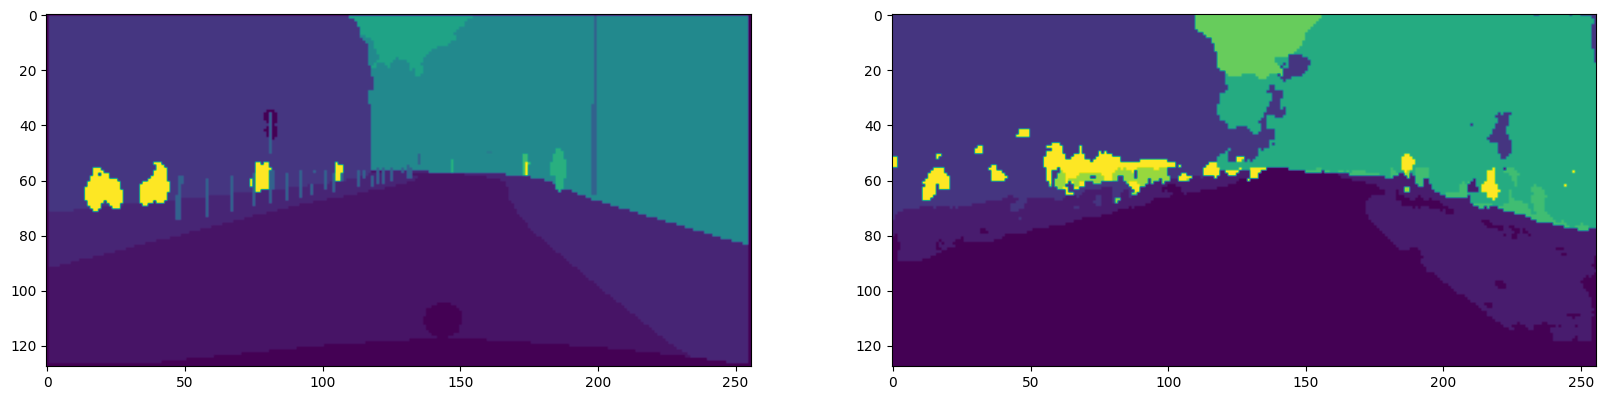

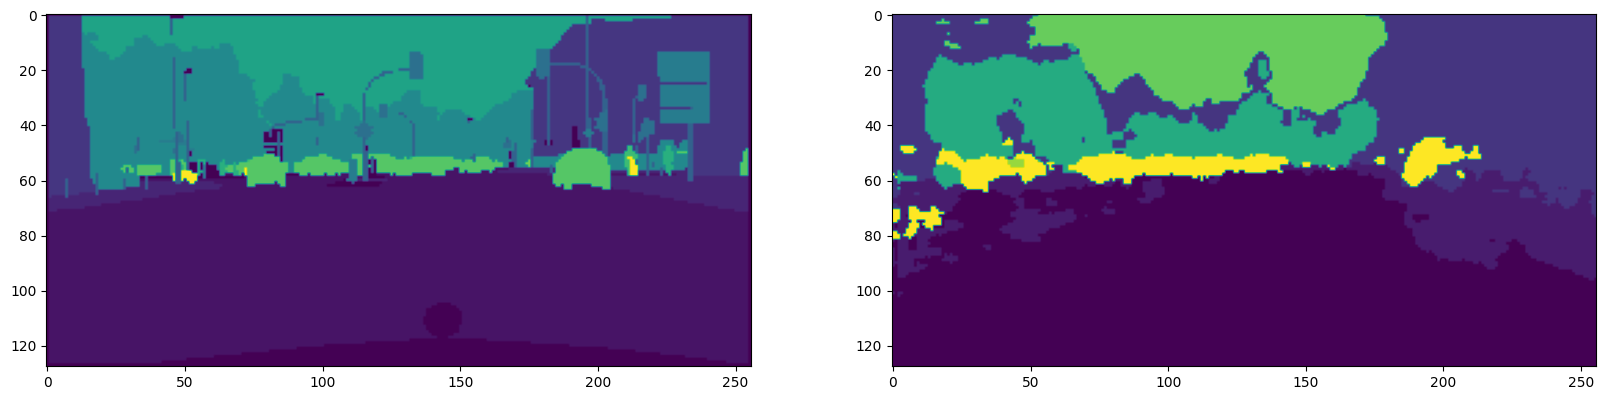

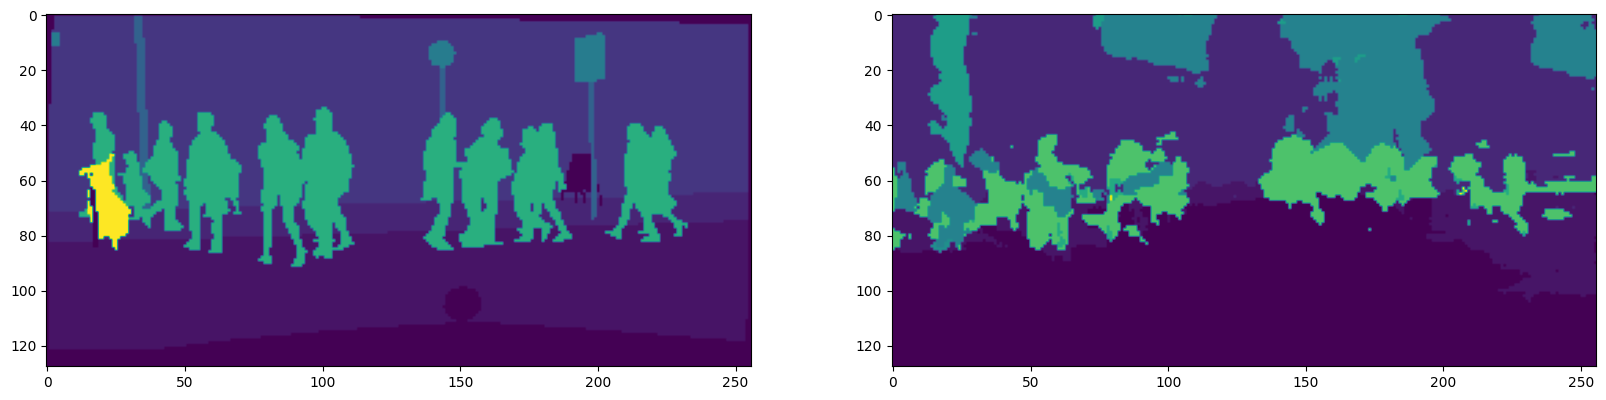

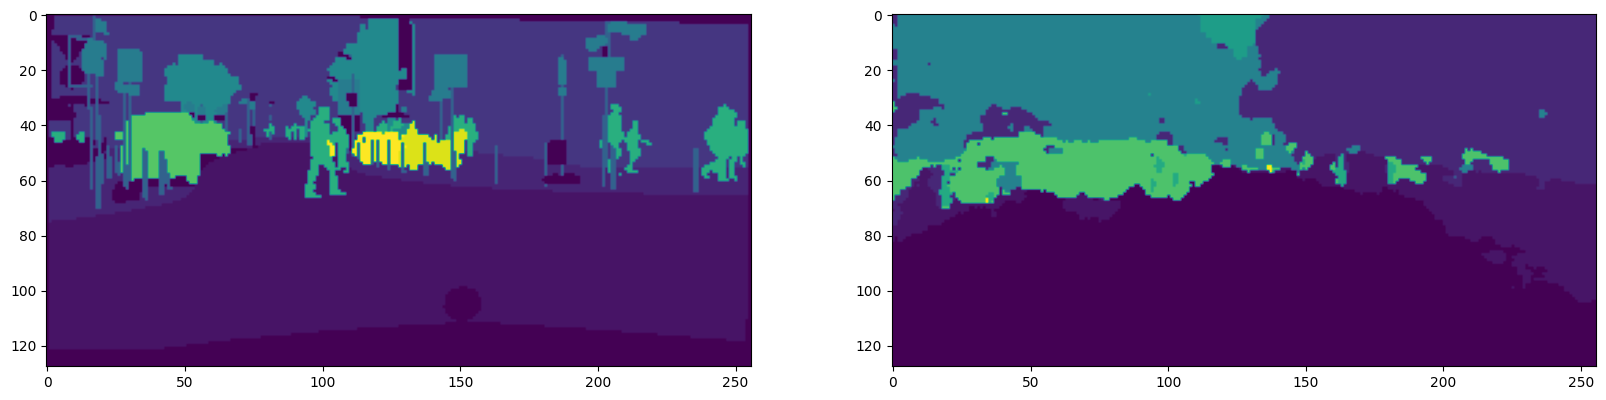

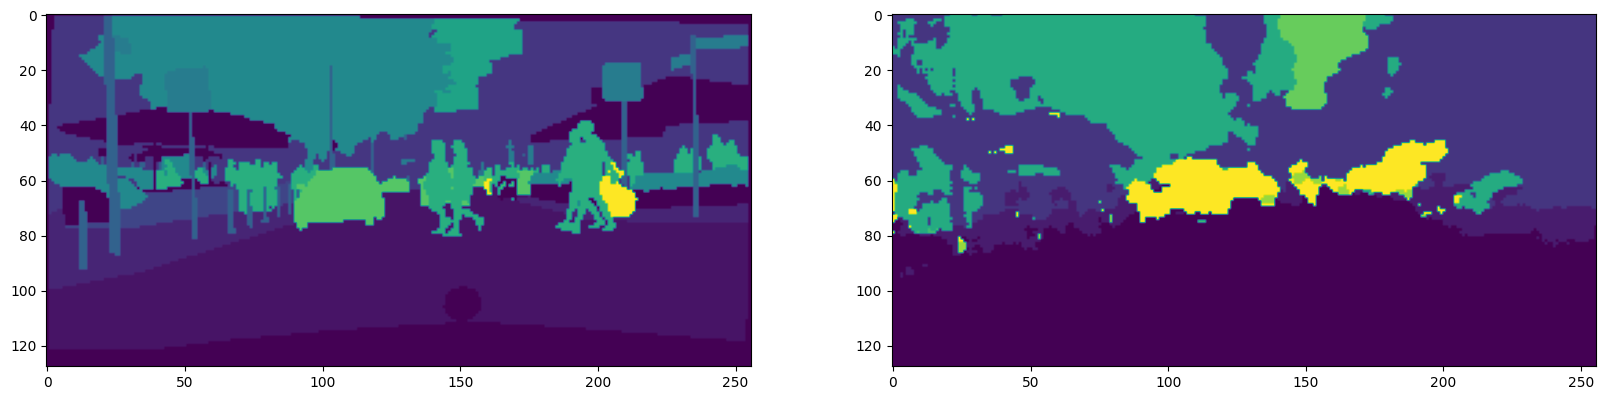

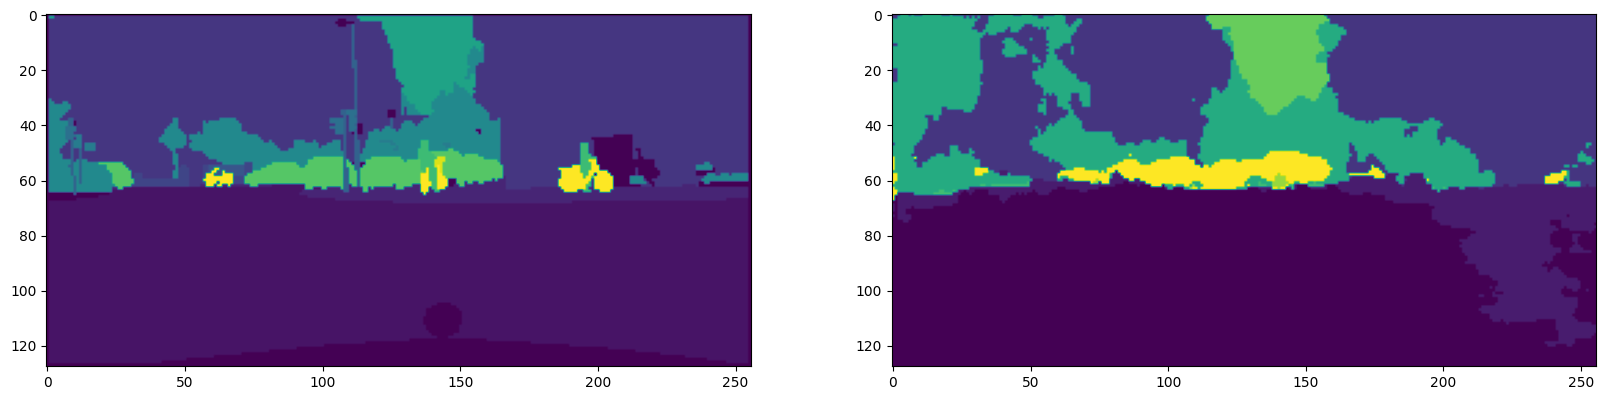

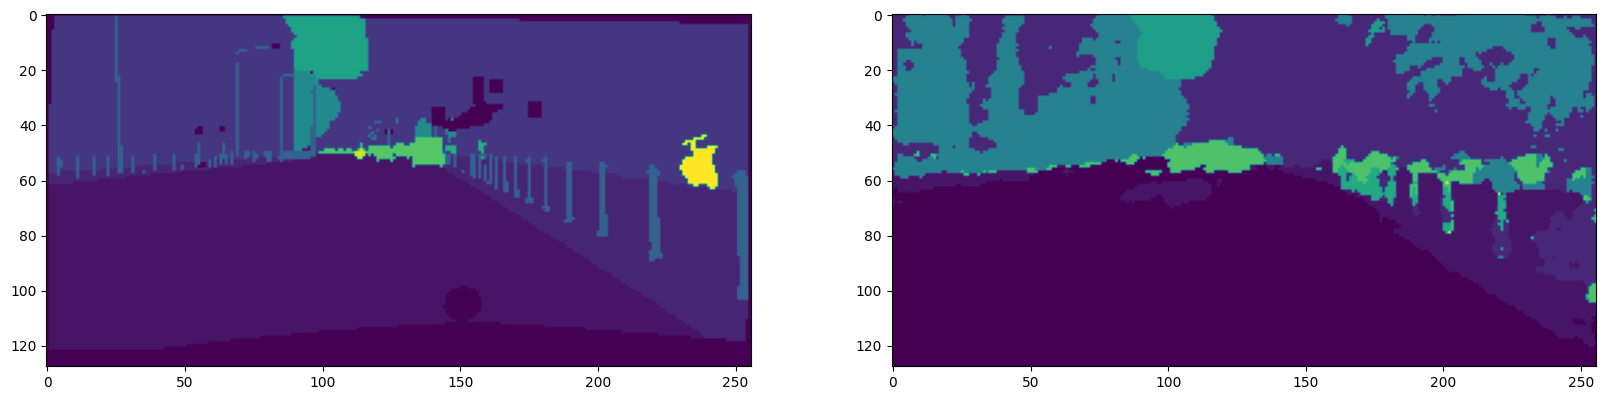

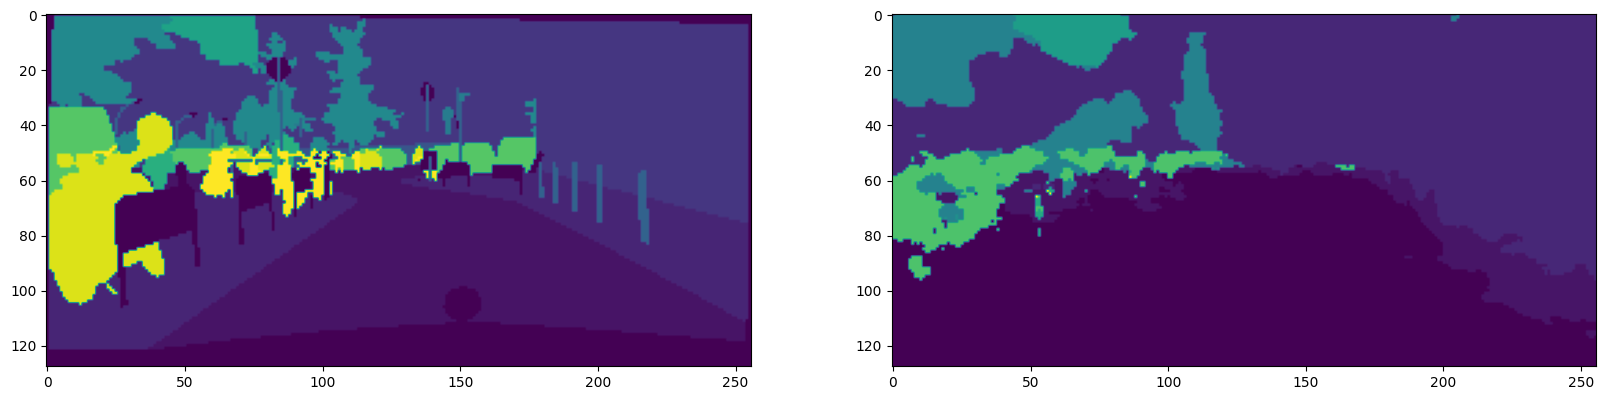

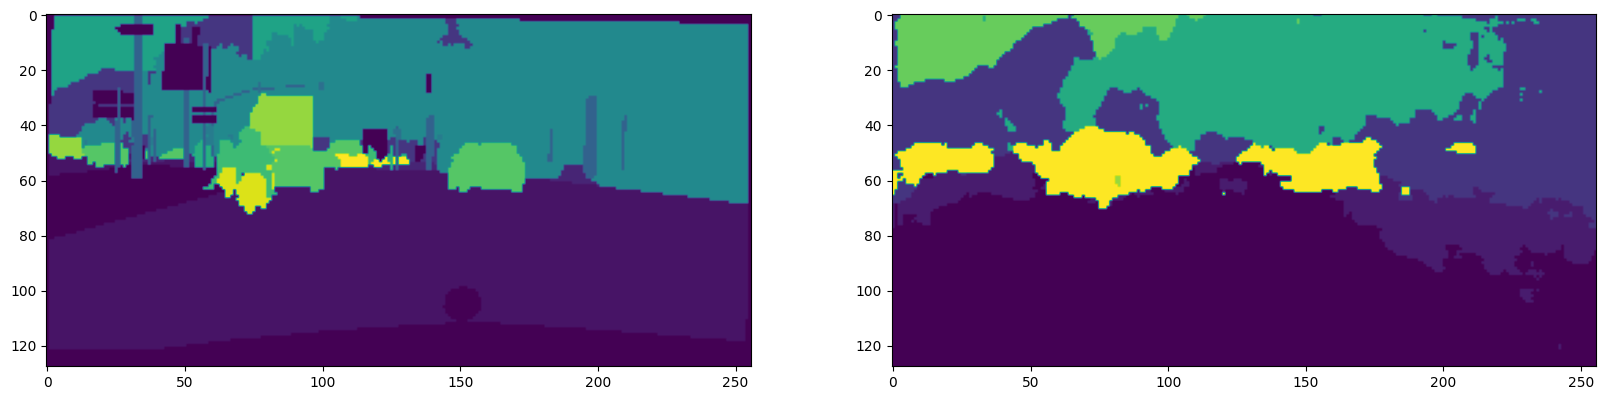

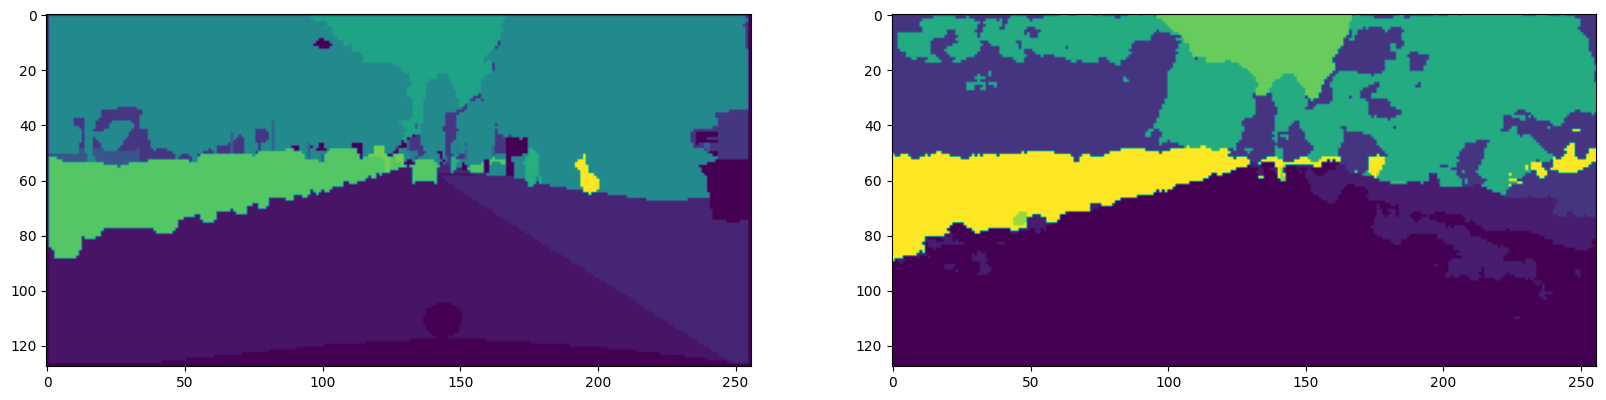

In [16]:
for file, seg_pred in zip(files, segmentations):
    seg_label = np.load(VALID_DIR + 'label/' + file)
    
    plt.figure(figsize = (20,10))
    plt.subplot(1, 2, 1)
    plt.imshow(seg_label)

    plt.subplot(1, 2, 2)
    plt.imshow(seg_pred)

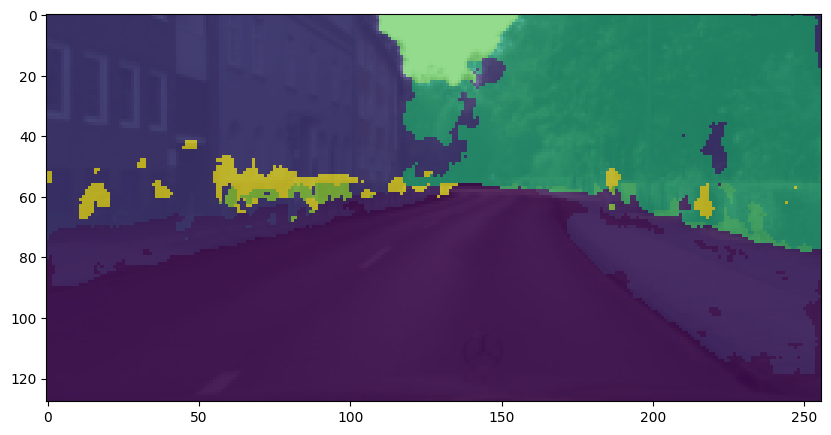

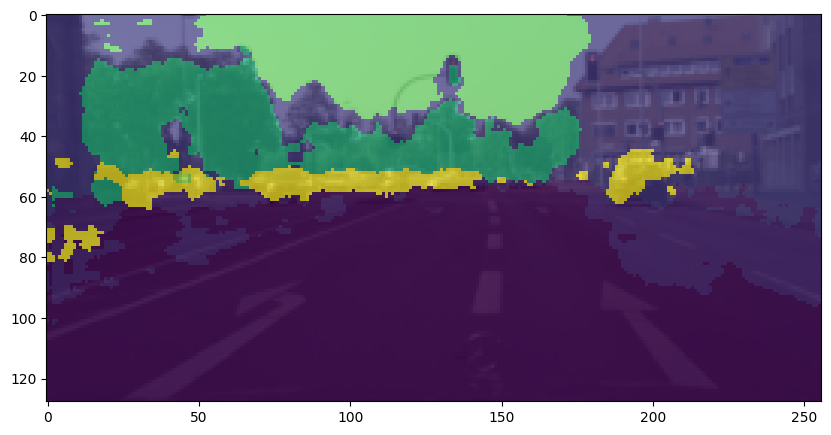

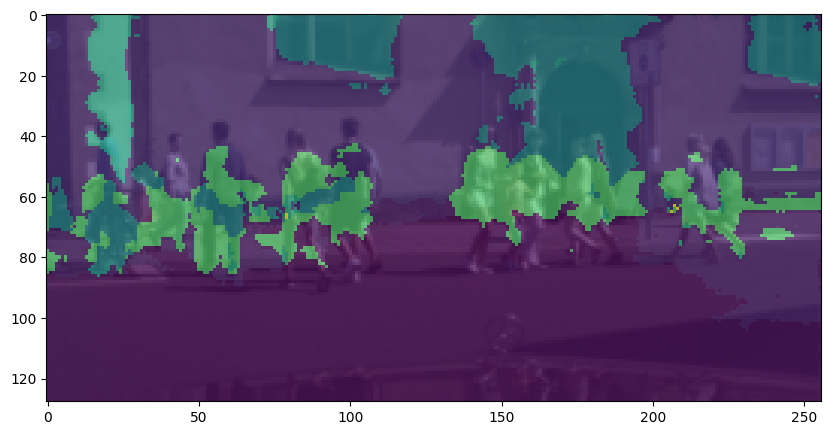

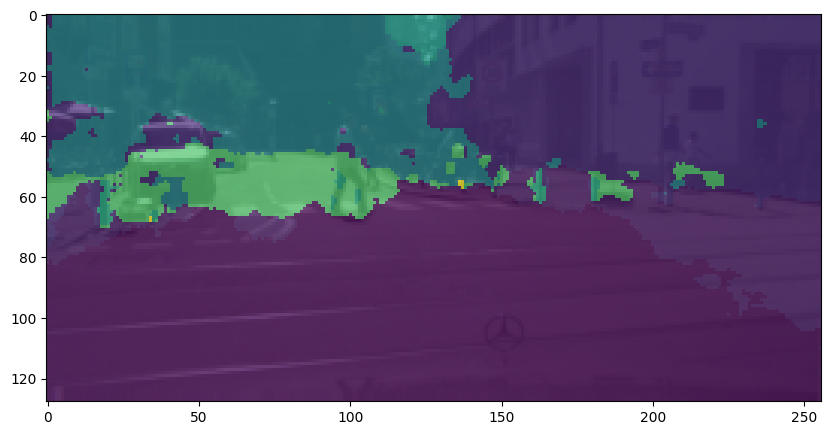

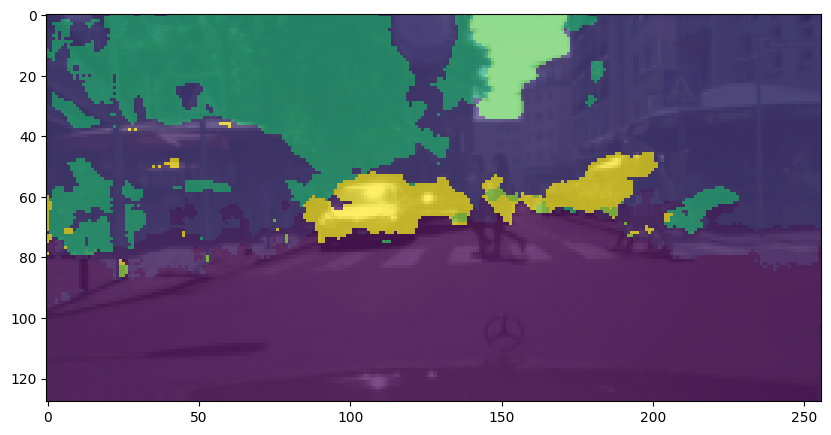

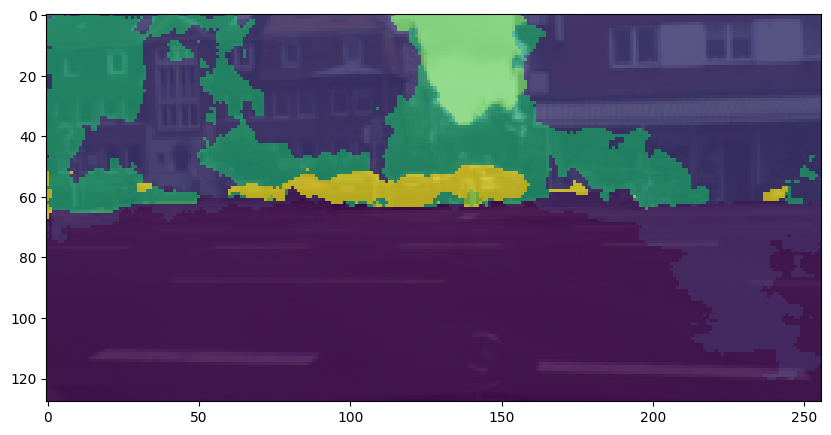

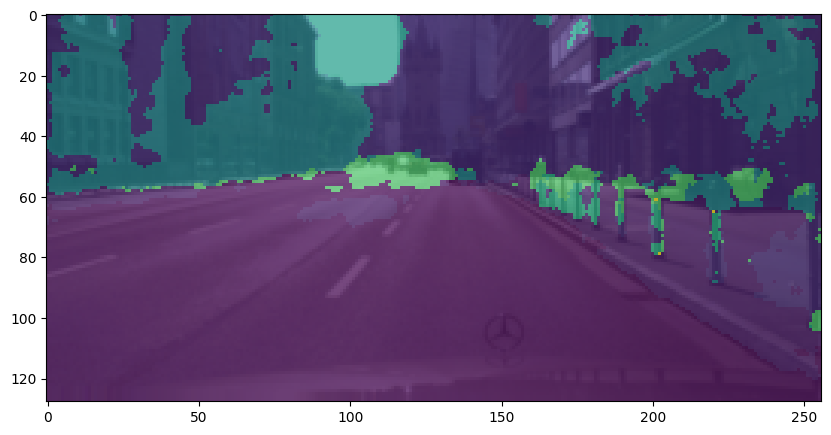

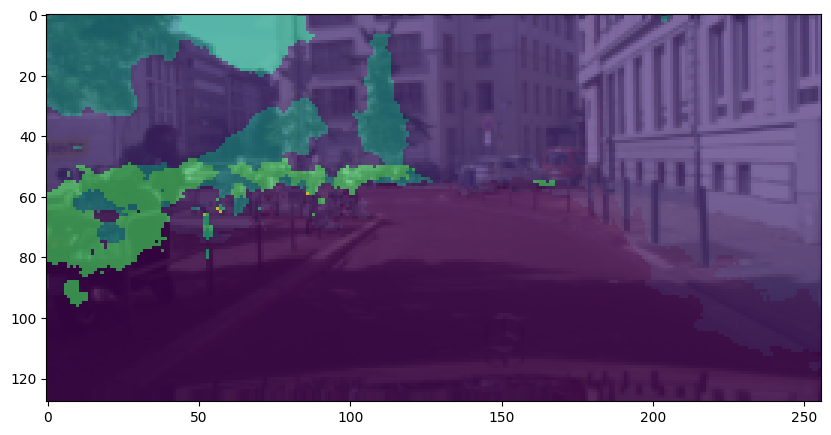

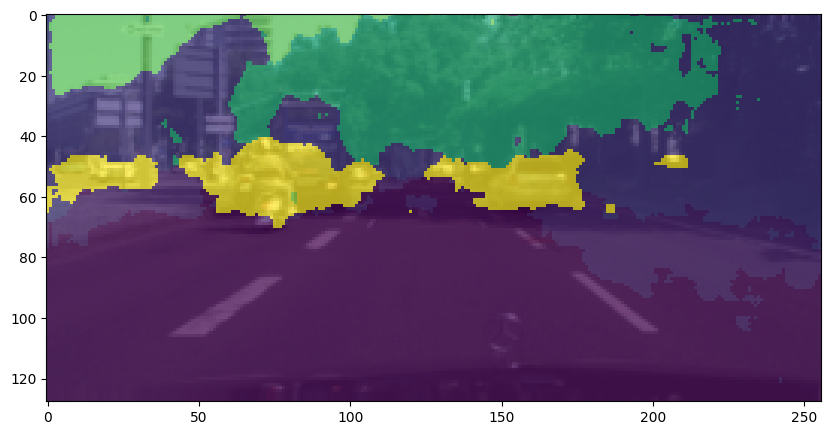

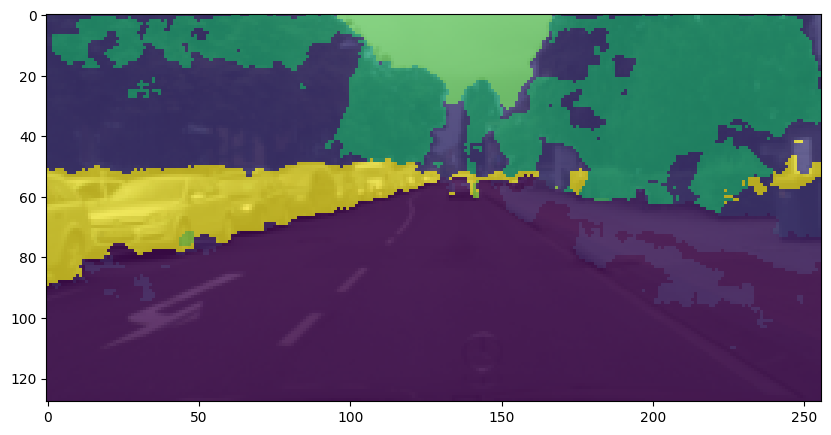

In [17]:
for file, seg_pred in zip(files, segmentations):
    img = np.load(VALID_DIR + 'image/' + file)
    
    plt.figure(figsize = (10,10))
    plt.imshow(img)
    plt.imshow(seg_pred, alpha = 0.7)

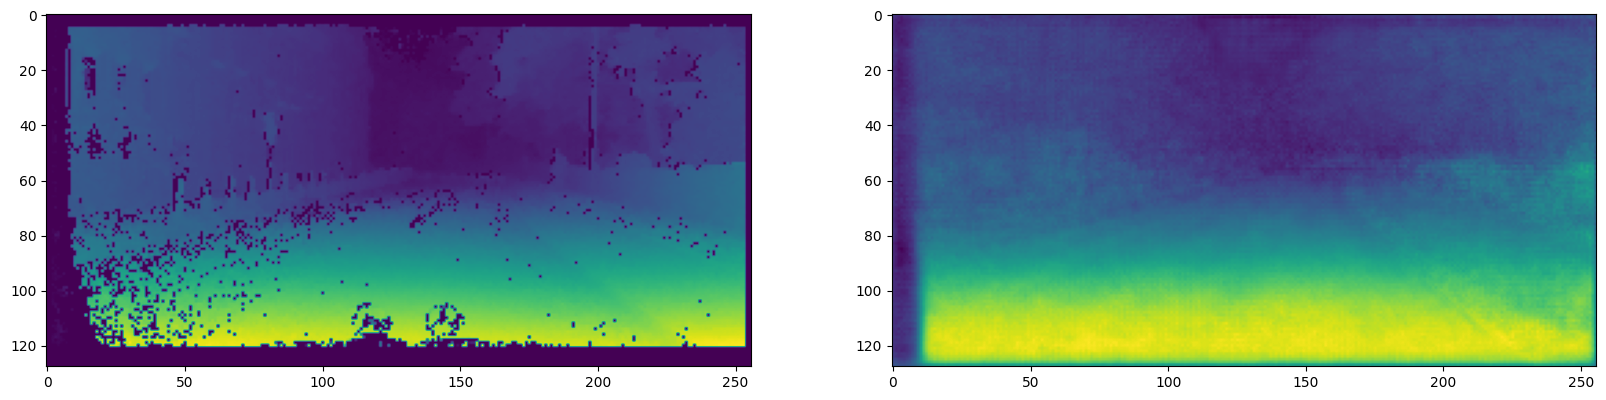

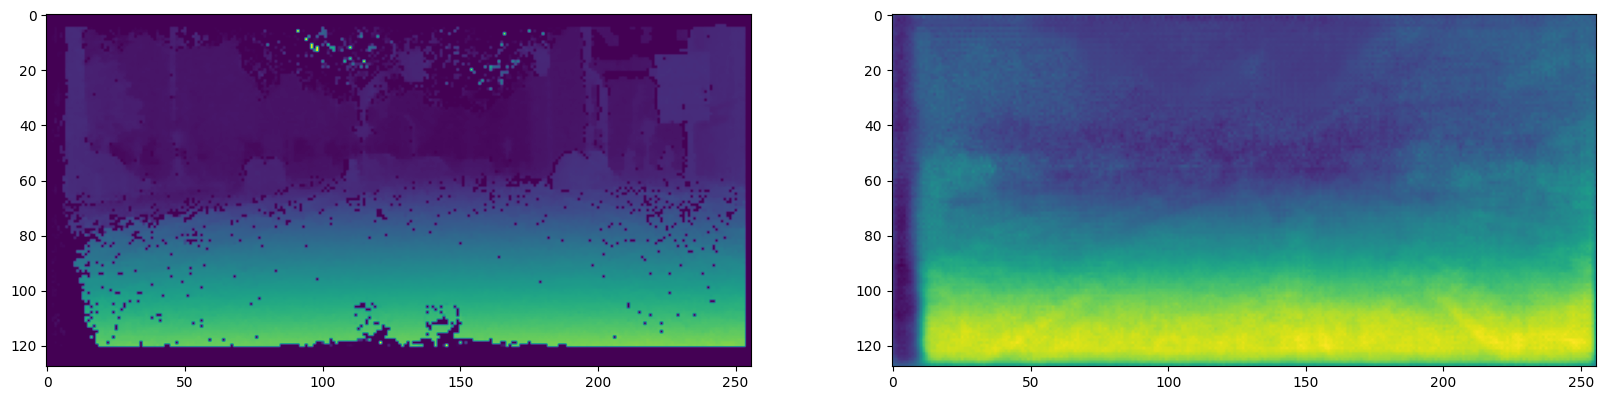

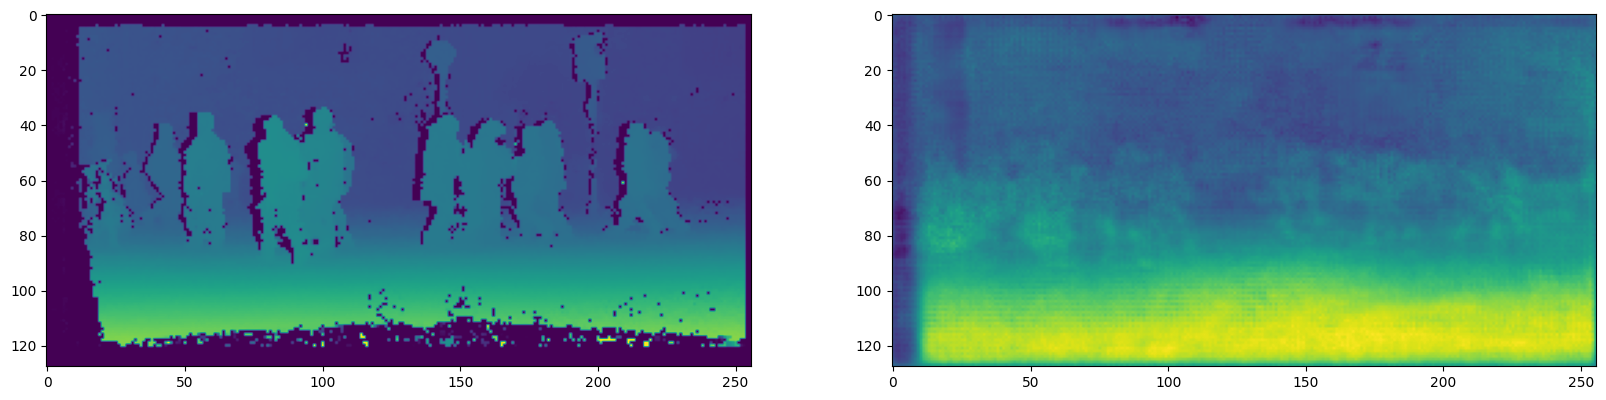

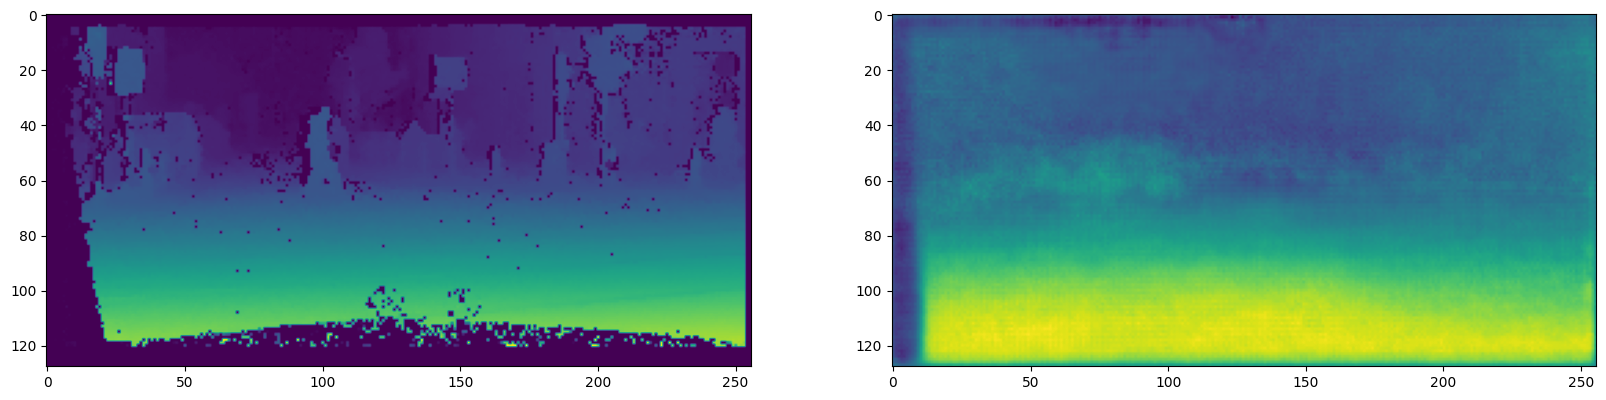

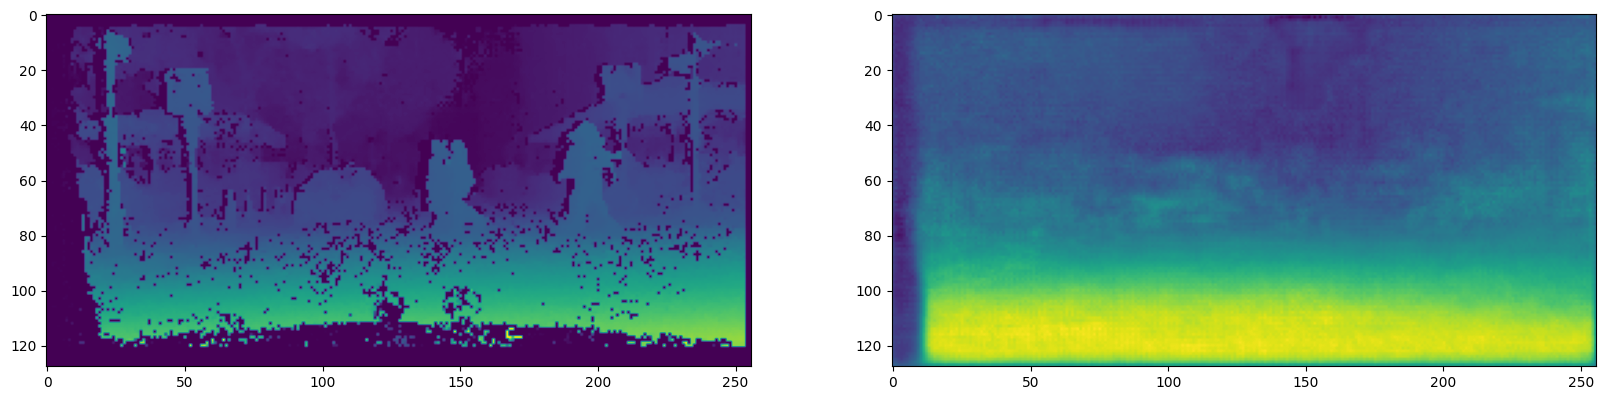

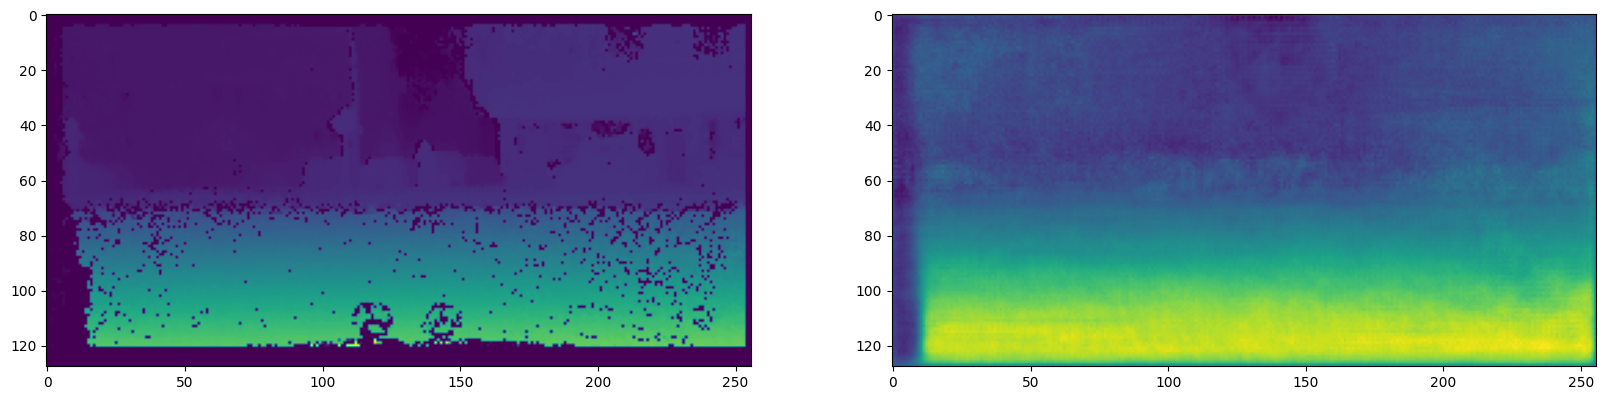

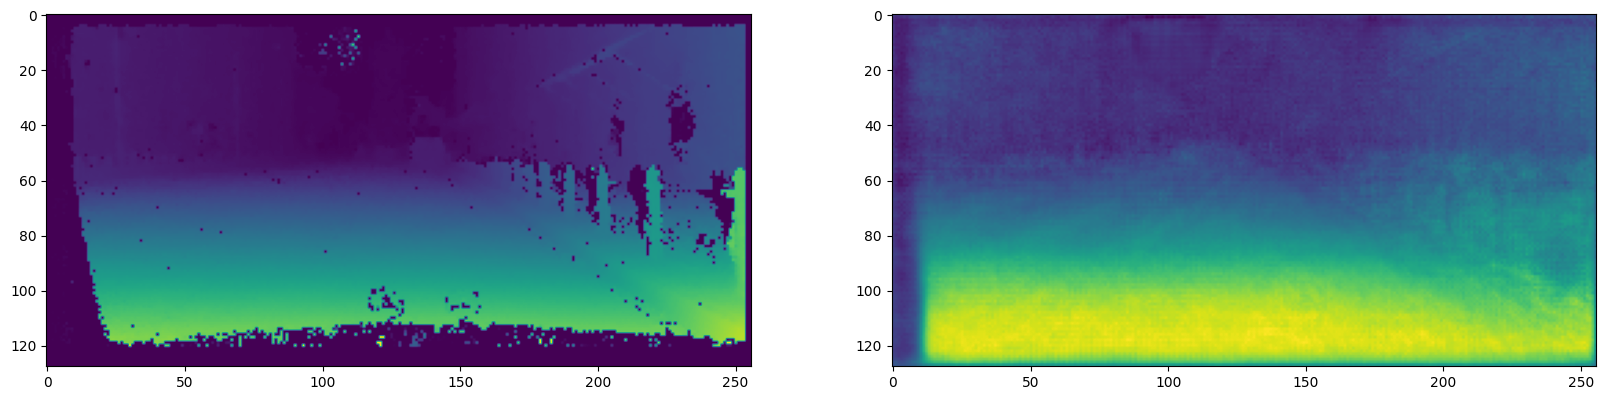

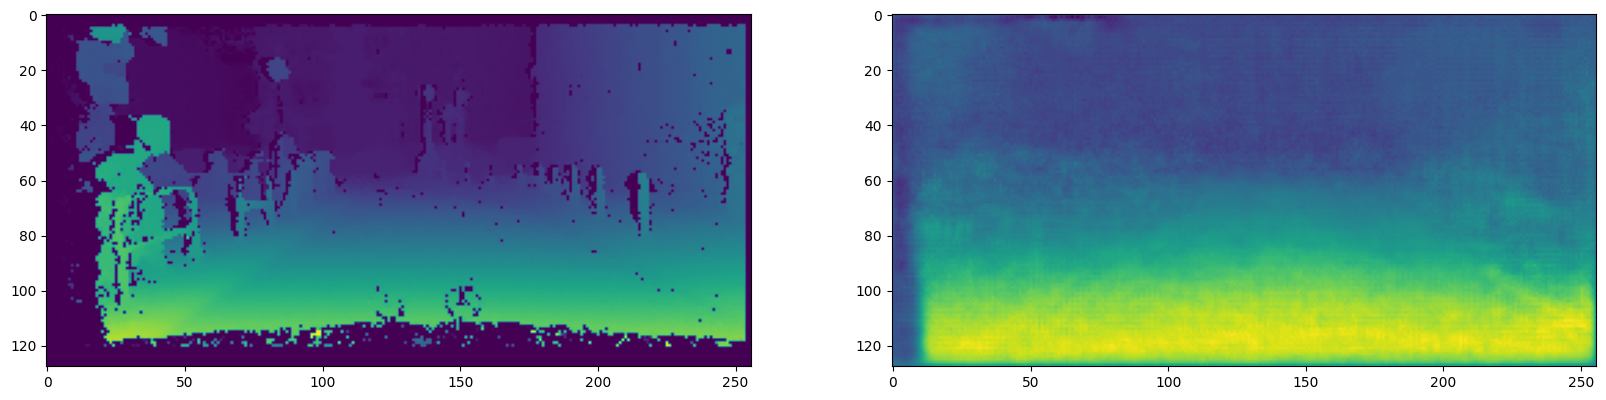

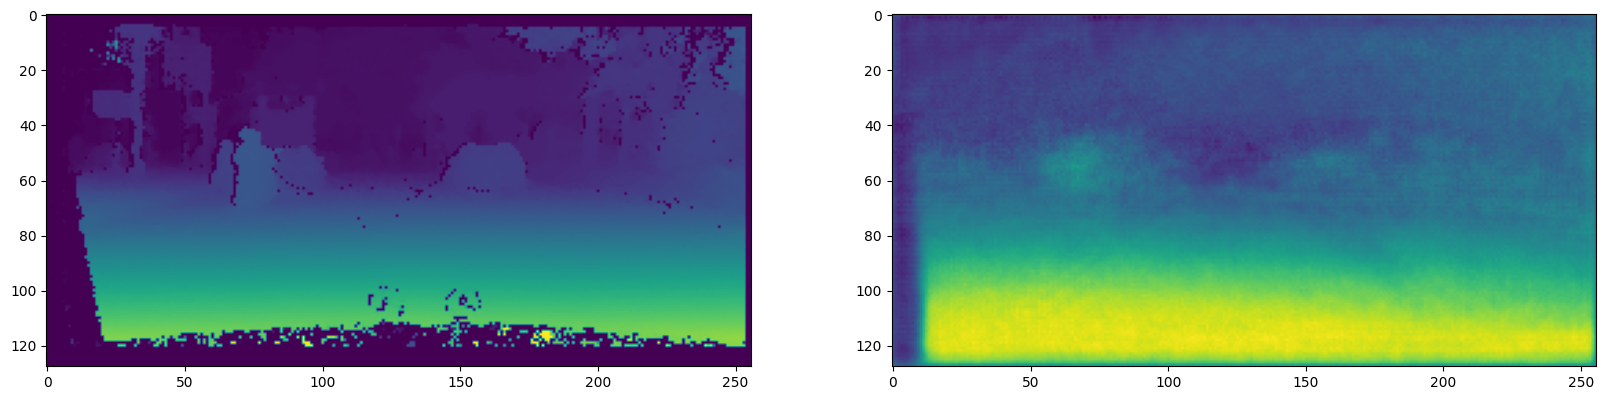

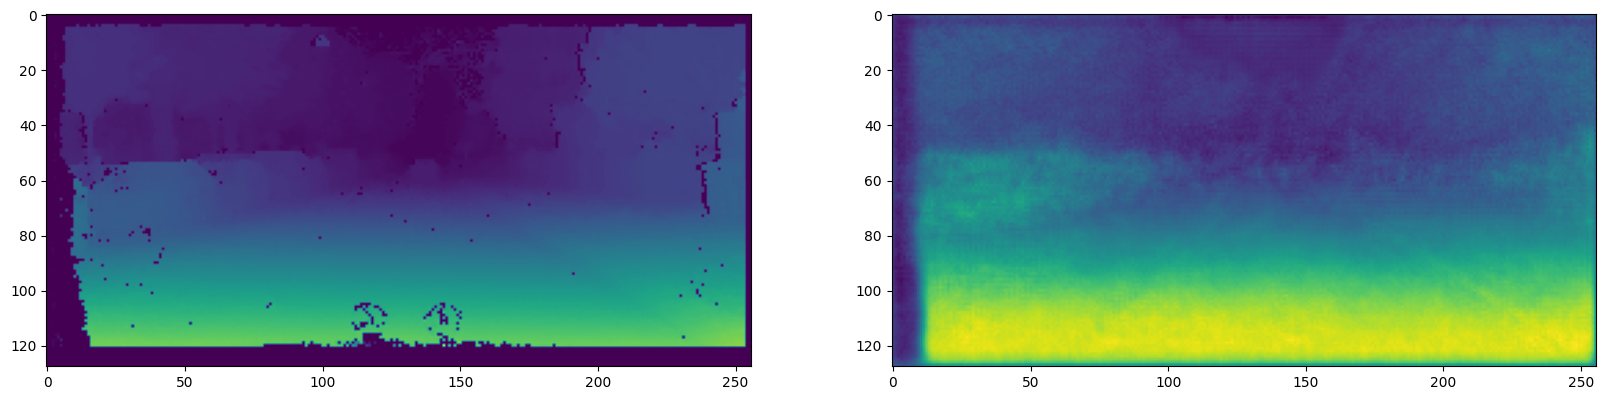

In [18]:
for file, depth_pred in zip(files, depths):
    depth_label = np.load(VALID_DIR + 'depth/' + file)
    
    plt.figure(figsize = (20,10))
    plt.subplot(1, 2, 1)
    plt.imshow(depth_label)

    plt.subplot(1, 2, 2)
    plt.imshow(depth_pred)

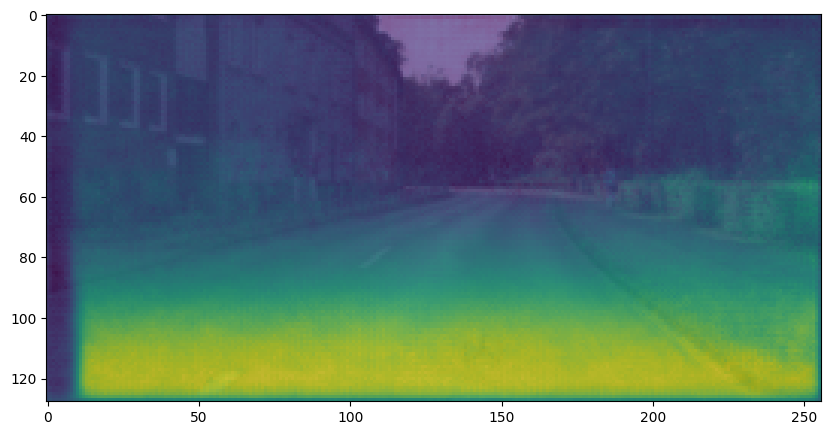

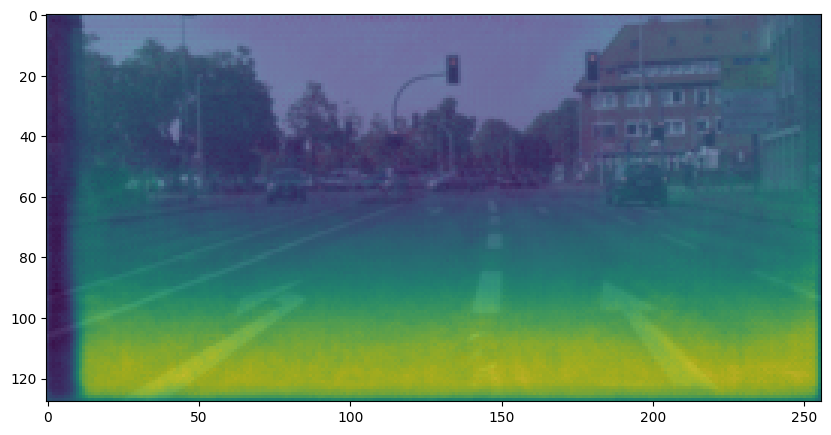

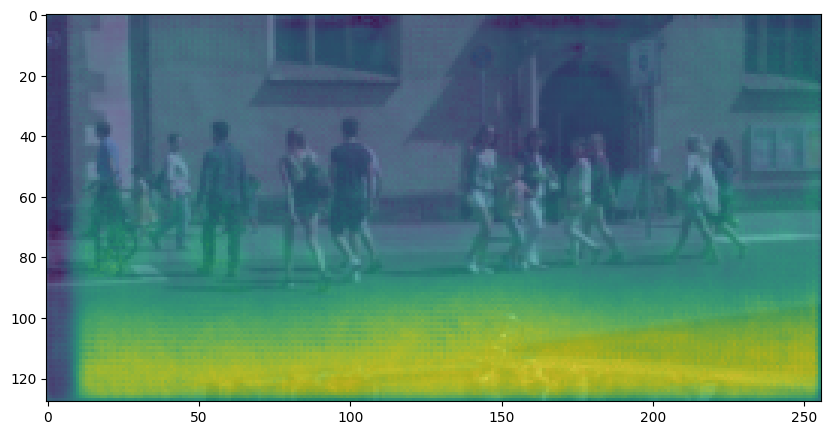

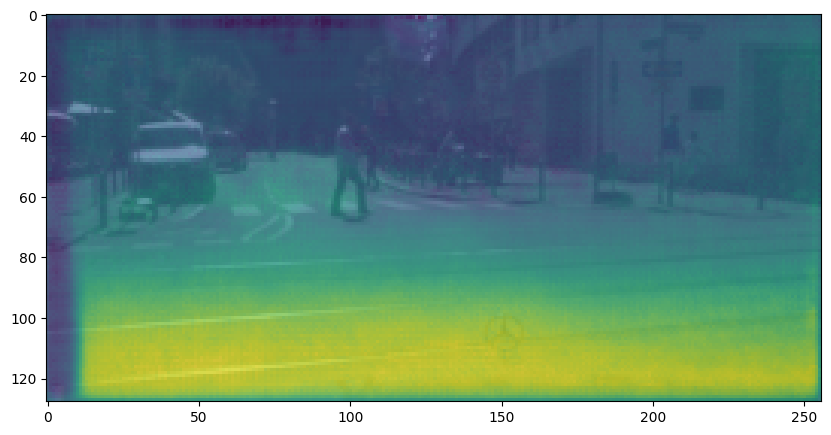

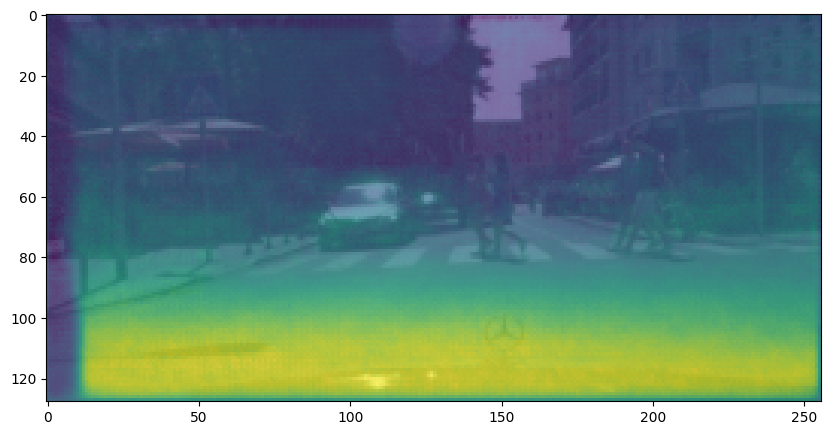

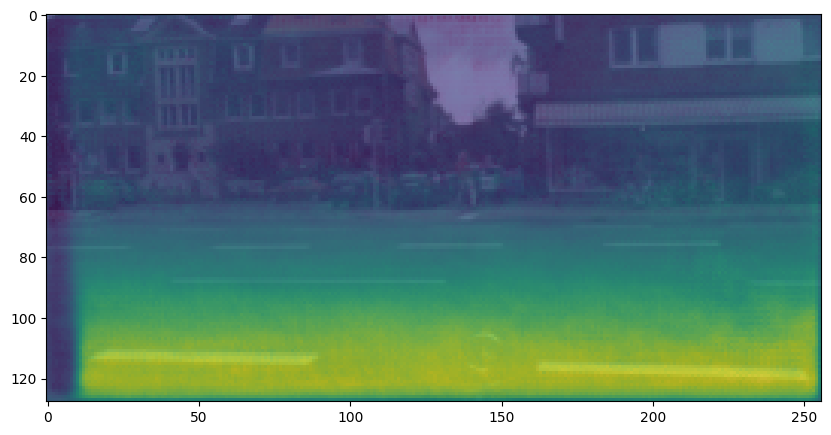

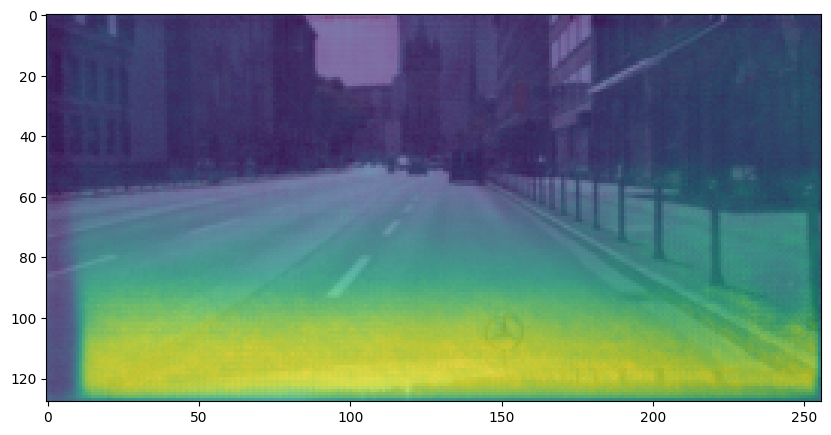

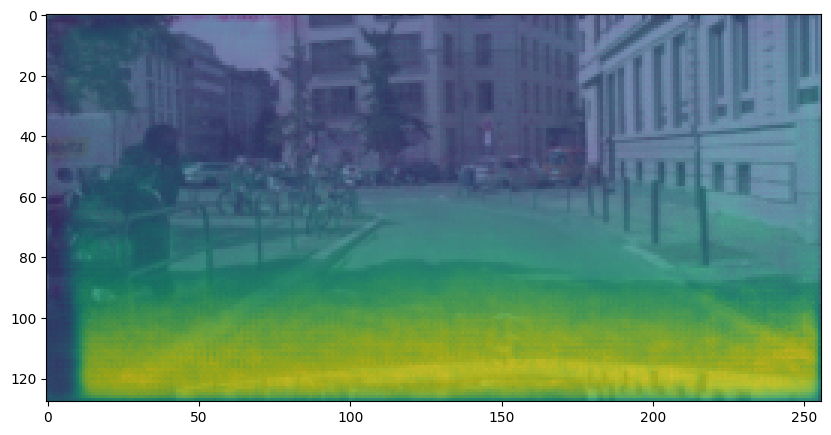

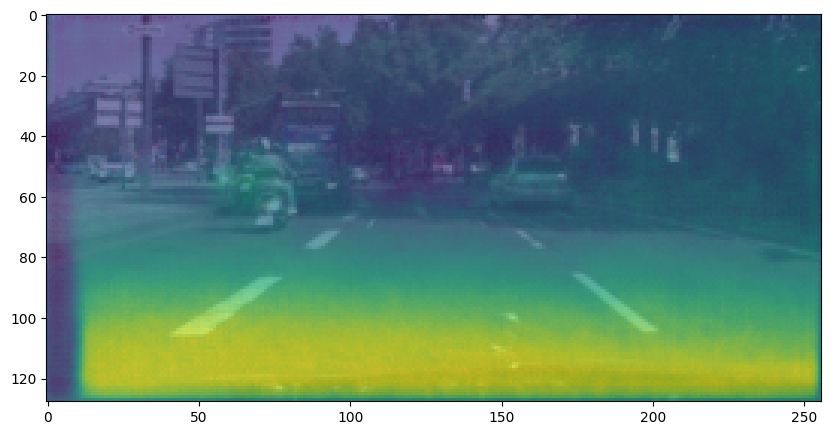

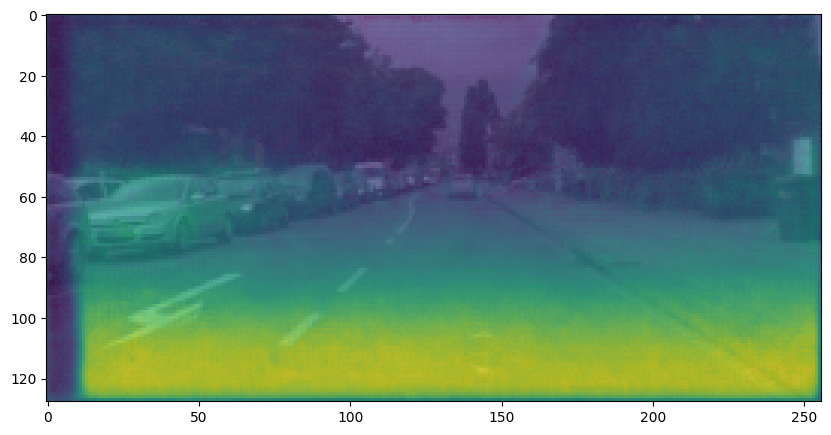

In [19]:
for file, depth_pred in zip(files, depths):
    img = np.load(VALID_DIR + 'image/' + file)
    
    plt.figure(figsize = (10,10))
    plt.imshow(img)
    plt.imshow(depth_pred, alpha = 0.7)